# Train an Agent using Generative Adversarial Imitation Learning

The idea of generative adversarial imitation learning is to train a discriminator network to distinguish between expert trajectories and learner trajectories.
The learner is trained using a traditional reinforcement learning algorithm such as PPO and is rewarded for trajectories that make the discriminator think that it was an expert trajectory.

As usual, we first need an expert. 
Note that we now use a variant of the CartPole environment from the seals package, which has fixed episode durations. Read more about why we do this [here](https://imitation.readthedocs.io/en/latest/guide/variable_horizon.html).

In [1]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
import gym
import seals

env = gym.make("seals/CartPole-v0")
expert = PPO(
    policy=MlpPolicy,
    env=env,
    seed=0,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
    n_steps=64,
)
expert.learn(1000)  # Note: set to 100000 to train a proficient expert

/home/luis/anaconda3/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


We generate some expert trajectories, that the discriminator needs to distinguish from the learner's trajectories.

In [3]:
from imitation.data import rollout
from imitation.data.types import TrajectoryWithRew
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np

rollouts = rollout.rollout(
    expert,
    DummyVecEnv([lambda: RolloutInfoWrapper(gym.make("seals/CartPole-v0"))] * 5),
    rollout.make_sample_until(min_timesteps=None, min_episodes=60),
)
traj = []
tr = TrajectoryWithRew([0,0],[1],None,terminal=True,rews=np.array([1.0]))
traj.append(tr)
print(traj)
print(type(traj))

print(rollouts)
print(type(rollouts))

/home/luis/anaconda3/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


[TrajectoryWithRew(obs=[0, 0], acts=[1], infos=None, terminal=True, rews=array([1.]))]
<class 'list'>
[TrajectoryWithRew(obs=array([[-4.8595937e-03, -4.7170568e-02, -4.6847571e-02,  3.4588818e-02],
       [-5.8030048e-03, -2.4159050e-01, -4.6155795e-02,  3.1213060e-01],
       [-1.0634814e-02, -4.3602553e-01, -3.9913181e-02,  5.8990759e-01],
       ...,
       [-1.7566734e+02, -3.4473858e+01,  1.7503312e+00, -1.6503677e+01],
       [-1.7635681e+02, -3.4409557e+01,  1.4202576e+00, -1.6197180e+01],
       [-1.7704501e+02, -3.3993279e+01,  1.0963140e+00, -1.6000149e+01]],
      dtype=float32), acts=array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0

Now we are ready to set up our GAIL trainer.
Note, that the `reward_net` is actually the network of the discriminator.
We evaluate the learner before and after training so we can see if it made any progress.

In [8]:
from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

import gym
import seals


venv = DummyVecEnv([lambda: gym.make("seals/CartPole-v0")] * 8)
learner = PPO(
    env=venv,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0003,
    n_epochs=10,
)
reward_net = BasicRewardNet(
    venv.observation_space, venv.action_space, normalize_input_layer=RunningNorm
)
gail_trainer = GAIL(
    demonstrations=rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=venv,
    gen_algo=learner,
    reward_net=reward_net,
)

"""
learner_rewards_before_training, _ = evaluate_policy(
    learner, venv, 100, return_episode_rewards=True
)
gail_trainer.train(20000)  # Note: set to 300000 for better results
learner_rewards_after_training, _ = evaluate_policy(
    learner, venv, 100, return_episode_rewards=True
)
"""

[('__abstractmethods__', frozenset()), ('__annotations__', {'venv': <class 'stable_baselines3.common.vec_env.base_vec_env.VecEnv'>, 'venv_train': <class 'stable_baselines3.common.vec_env.base_vec_env.VecEnv'>}), ('__class__', <class 'abc.ABCMeta'>), ('__dict__', mappingproxy({'__module__': 'imitation.algorithms.adversarial.gail', '__doc__': 'Generative Adversarial Imitation Learning (`GAIL`_).\n\n    .. _GAIL: https://arxiv.org/abs/1606.03476\n    ', '__init__': <function GAIL.__init__ at 0x7f3bac7f9c10>, 'logits_gen_is_high': <function GAIL.logits_gen_is_high at 0x7f3bac7f9ca0>, 'reward_train': <property object at 0x7f3bac9ebea0>, 'reward_test': <property object at 0x7f3bac9ebae0>, '__parameters__': (), '__abstractmethods__': frozenset(), '_abc_impl': <_abc_data object at 0x7f3bac92d5a0>})), ('__doc__', 'Generative Adversarial Imitation Learning (`GAIL`_).\n\n    .. _GAIL: https://arxiv.org/abs/1606.03476\n    '), ('__module__', 'imitation.algorithms.adversarial.gail'), ('__orig_bases

'\nlearner_rewards_before_training, _ = evaluate_policy(\n    learner, venv, 100, return_episode_rewards=True\n)\ngail_trainer.train(20000)  # Note: set to 300000 for better results\nlearner_rewards_after_training, _ = evaluate_policy(\n    learner, venv, 100, return_episode_rewards=True\n)\n'

When we look at the histograms of rewards before and after learning, we can see that the learner is not perfect yet, but it made some progress at least.
If not, just re-run the above cell.

8.54
8.44


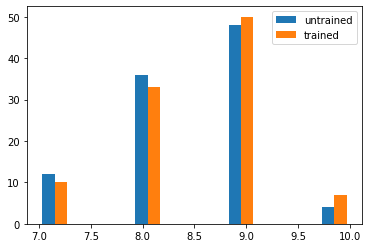

In [4]:
import matplotlib.pyplot as plt
import numpy as np

print(np.mean(learner_rewards_after_training))
print(np.mean(learner_rewards_before_training))

plt.hist(
    [learner_rewards_before_training, learner_rewards_after_training],
    label=["untrained", "trained"],
)
plt.legend()
plt.show()

In [5]:
learner_rewards_after_training

[8.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 8.0,
 9.0,
 9.0,
 9.0,
 8.0,
 9.0,
 9.0,
 8.0,
 9.0,
 9.0,
 8.0,
 7.0,
 9.0,
 9.0,
 8.0,
 8.0,
 8.0,
 7.0,
 8.0,
 8.0,
 9.0,
 8.0,
 9.0,
 9.0,
 8.0,
 9.0,
 9.0,
 8.0,
 9.0,
 9.0,
 9.0,
 8.0,
 8.0,
 9.0,
 8.0,
 9.0,
 8.0,
 9.0,
 7.0,
 8.0,
 7.0,
 8.0,
 9.0,
 9.0,
 8.0,
 8.0,
 8.0,
 7.0,
 10.0,
 7.0,
 10.0,
 8.0,
 7.0,
 8.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 9.0,
 8.0,
 10.0,
 9.0,
 9.0,
 9.0,
 7.0,
 9.0,
 8.0,
 9.0,
 9.0,
 8.0,
 8.0,
 9.0,
 7.0,
 10.0,
 9.0,
 8.0,
 9.0,
 9.0,
 10.0,
 9.0,
 10.0,
 8.0,
 9.0,
 9.0,
 8.0,
 8.0,
 9.0,
 7.0,
 9.0,
 10.0,
 8.0,
 9.0,
 9.0]